## Part 4: Human-in-the-loop

Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.


LangGraph supports `human-in-the-loop` workflows in a number of ways. In this section, we will use LangGraph's `interrupt_before` functionality to always break the tool node.

In [ ]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOllama(model="llama3.2", temperature=0)
# llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[search_tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

Now, compile the graph, specifying to `interrupt_before` the `tools` node.

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

config = {"configurable": {"thread_id": "1"}}

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a9d6165b-b85d-445b-bff2-64731735a68a)
 Call ID: a9d6165b-b85d-445b-bff2-64731735a68a
  Args:
    query: LangGraph


Let's inspect the graph state to confirm it worked.

In [ ]:
snapshot = graph.get_state(config)

snapshot.next

('tools',)

Notice that unlike last time, the "next" node is set to 'tools'. We've interrupted here! Let's check the tool invocation.

In [ ]:
existing_message = snapshot.values["messages"][-1]

existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph'},
  'id': 'a9d6165b-b85d-445b-bff2-64731735a68a',
  'type': 'tool_call'}]

This query doesn't seem that reasonable but we will leave it as is. 

The simplest thing the human can do is just let the graph continue executing. Let's do that below.

Next, continue the graph! Passing in `None` will just let the graph continue where it left off, without adding anything new to the state.

In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted

events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (a9d6165b-b85d-445b-bff2-64731735a68a)
 Call ID: a9d6165b-b85d-445b-bff2-64731735a68a
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agent large language model (LLM) applications. Learn how to use LangGraph to create stateful, flexible, and scalable systems with nodes, edges, and state management."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a low-level framework that allows you to create stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to b

Congrats! You've used an `interrupt` to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. 

This opens up the potential UIs you can create with your AI systems. Since we have already added a checkpointer, the graph can be paused indefinitely and resumed at any time as if nothing had happened.

Next, we'll explore how to further customize the bot's behavior using custom state updates.

## Part 5: Manually Updating the State

In the previous section, we showed how to interrupt a graph so that a human could inspect its actions. This lets the human read the state, but if they want to change their agent's course, they'll need to have `write ` access.

LangGraph lets you manually update state! Updating the state lets you control the agent's trajectory by modifying its actions (even modifying the past!). This capability is particularly useful when you want to correct the agent's mistakes, explore alternative paths, or guide the agent towards a specific goal.

We'll show how to update a checkpointed state below. As before, first, define your graph. We'll reuse the exact same graph as before.

In [ ]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm = ChatOllama(model="llama3.2", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "I'm learning LangGraph. Could you do some research on it for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (c5b5ff1b-6525-4e16-aed9-4c36a9534184)
 Call ID: c5b5ff1b-6525-4e16-aed9-4c36a9534184
  Args:
    query: LangGraph


So far, all of this is an exact repeat of the previous section. The LLM just requested to use the search engine tool and our graph was interrupted. If we proceed as before, the tool will be called to search the web.


But what if the user wants to intercede? What if we think the chat bot doesn't need to use the tool?

Let's directly provide the correct response!

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "LangGraph is a library for building stateful, multi-actor applications with LLMs."
)

new_messages = [
    # The LLM (API) expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),

    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,

    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

LangGraph is a library for building stateful, multi-actor applications with LLMs.


Last 2 messages;
[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='8ccbe1d5-ef2f-47cc-840f-89672b38db6a', tool_call_id='c5b5ff1b-6525-4e16-aed9-4c36a9534184'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='b9eab86b-6100-431a-b098-98f1a5625169')]


**Note:** Our new messages are appended to the messages already in the state. This is because of how we defined the State type

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

We annotated `messages` with the pre-built `add_messages` function. This instructs the graph to always append values to the existing list, rather than overwriting the list directly. The same logic is applied here, so the messages we passed to `update_state` were appended in the same way!



The `update_state` function operates as if it were one of the nodes in your graph! By default, the update operation uses the node that was last executed, but you can manually specify it below. 


Let's add an update and tell the graph to treat it as if it came from the "chatbot".

In [ ]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa7ecf-65cc-603e-8003-6928e455b9e3'}}

Lets inspect the current state as before to confirm the checkpoint reflects our manual updates.

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='c0b8843f-2318-4605-a4c5-6d46dd749465', tool_call_id='18cbfb66-7b4c-4c48-8488-6588bd18be44'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='5545754b-d7be-4918-a3b4-c78dd9b41ecc'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='5fe10241-ab04-4579-96eb-76d8345ba322')]
()


In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', id='c0b8843f-2318-4605-a4c5-6d46dd749465', tool_call_id='18cbfb66-7b4c-4c48-8488-6588bd18be44'), AIMessage(content='LangGraph is a library for building stateful, multi-actor applications with LLMs.', additional_kwargs={}, response_metadata={}, id='5545754b-d7be-4918-a3b4-c78dd9b41ecc'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='5fe10241-ab04-4579-96eb-76d8345ba322')]
()


**Notice:** that we've continued to add AI messages to the state. Since we are acting as the chatbot and responding with an AIMessage that doesn't contain tool_calls, the graph knows that it has entered a finished state (next is empty).

#### **What if you want to overwrite existing messages?***

The `add_messages` function we used to annotate our graph's `State` above controls how updates are made to the `messages` key. This function looks at any message IDs in the new `messages` list. If the ID matches a message in the existing state, `add_messages` overwrites the existing message with the new content.

As an example, let's update the tool invocation to make sure we get good results from our search engine! 

First, start a new thread:

In [ ]:
user_input = "I'm learning LangGraph. Could you do some research on it for me?"

config = {"configurable": {"thread_id": "2"}}  # we'll use thread_id = 2 here

events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1ab6e1c1-4abe-43df-a0b6-0543586d68ca)
 Call ID: 1ab6e1c1-4abe-43df-a0b6-0543586d68ca
  Args:
    query: LangGraph


**Next,** let's update the tool invocation for our agent. Maybe we want to make the search more specific.

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])

new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "LangGraph framework for language models"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-28bfa347-4ec5-4ea7-aed5-841992873c05-0
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph'}, 'id': '1ab6e1c1-4abe-43df-a0b6-0543586d68ca', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': 'LangGraph framework for language models'}, 'id': '1ab6e1c1-4abe-43df-a0b6-0543586d68ca', 'type': 'tool_call'}
Message ID run-28bfa347-4ec5-4ea7-aed5-841992873c05-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': 'LangGraph framework for language models'},
  'id': '1ab6e1c1-4abe-43df-a0b6-0543586d68ca',
  'type': 'tool_call'}]

Notice that we've modified the AI's tool invocation to search for "LangGraph framework for language models" instead of the simple "LangGraph".

Resume the graph by streaming with an input of `None` and the existing config.

In [ ]:
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (1ab6e1c1-4abe-43df-a0b6-0543586d68ca)
 Call ID: 1ab6e1c1-4abe-43df-a0b6-0543586d68ca
  Args:
    query: LangGraph framework for language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.langchain.com/langgraph", "content": "LangGraph's flexible framework supports diverse control flows - single agent, multi-agent, hierarchical, sequential - and robustly handles realistic, complex scenarios. Ensure reliability with easy-to-add moderation and quality loops that prevent agents from veering off course. Use LangGraph Platform to templatize your cognitive"}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "Overview. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other L

Note: The graph queries the search engine using our updated query term - we were able to manually override the LLM's search here!


All of this is reflected in the graph's checkpointed memory, meaning if we continue the conversation, it will recall all the modified state.

In [ ]:
events = graph.stream(
    {
        "messages": (
            "user",
            "Remember what I'm learning about?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember what I'm learning about?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (bf6ccc6c-67c9-4a4a-aff4-c3b3bb69bab9)
 Call ID: bf6ccc6c-67c9-4a4a-aff4-c3b3bb69bab9
  Args:
    query: LangGraph framework for language models


Notice the LLM isn't smart enough to understand that it doesn't need to call a tool.

In [ ]:
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (bf6ccc6c-67c9-4a4a-aff4-c3b3bb69bab9)
 Call ID: bf6ccc6c-67c9-4a4a-aff4-c3b3bb69bab9
  Args:
    query: LangGraph framework for language models
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://medium.com/@monsuralirana/langgraph-vs-langchain-vs-langflow-vs-langsmith-which-one-to-use-why-69ee91e91000", "content": "LangGraph is a powerful framework for developers focused on designing complex language model pipelines using an agentic approach, rather than purely visual representation."}, {"url": "https://langchain-ai.github.io/langgraph/", "content": "Overview. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and pers

**That's It!**

You've used `interrupt_before` and `update_state` to manually modify the state as a part of a human-in-the-loop workflow. Interruptions and state modifications let you control how the agent behaves. Combined with persistent checkpointing, it means you can `pause` an action and `resume` at any point. Your user doesn't have to be available when the graph interrupts!


The graph code for this section is identical to previous ones. The key snippets to remember are to add `.compile(..., interrupt_before=[...])` `(or interrupt_after)` if you want to explicitly pause the graph whenever it reaches a node. 

Then you can use `update_state` to modify the checkpoint and control how the graph should proceed.


## Part 6: Customizing State

So far, we've relied on a simple state (it's just a list of messages!). 

You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. 


In this section, we will extend our chat bot with a new node to illustrate this.

In the previous examples, we involved a human deterministically: the graph always interrupted whenever an tool was invoked. 


What if we wanted our chat bot to have the choice of relying on a human?

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. 

For our convenience, we will include an `"ask_human"` flag in our graph state that we will flip if the LLM calls this tool.

Below, define the new graph, with an updated State

In [ ]:
from typing import Annotated

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):

    messages: Annotated[list, add_messages]
    
    # This flag is new
    ask_human: bool

Next, define a schema to show the model to let it decide to request assistance.

**NOTE**

This notebook uses Pydantic v2 `BaseModel`, which requires `langchain-core >= 0.3`. Using `langchain-core < 0.3` will result in errors due to mixing of Pydantic v1 and v2 `BaseModels`.

In [ ]:
!pip show langchain-core

Name: langchain-core
Version: 0.3.19
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /Users/user/miniforge3/envs/LLM_Bootcamp/lib/python3.11/site-packages
Requires: jsonpatch, langsmith, packaging, pydantic, PyYAML, tenacity, typing-extensions
Required-by: langchain, langchain-anthropic, langchain-community, langchain-groq, langchain-ollama, langchain-openai, langchain-text-splitters, langgraph, langgraph-checkpoint


In [ ]:
from pydantic import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

Next, define the chatbot node. 

The primary modification here is flip the `ask_human` flag if we see that the chat bot has invoked the `RequestAssistance` flag.

In [ ]:
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

llm = ChatOllama(model="llama3.2", temperature=0)

# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):

    response = llm_with_tools.invoke(state["messages"])

    ask_human = False

    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        
        ask_human = True
        
    return {"messages": [response], "ask_human": ask_human}


Next, create the graph builder and add the chatbot and tools nodes to the graph, same as before.

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_node("tools", ToolNode(tools=tools))

Next, create the `"human"` node. This `node` function is mostly a placeholder in our graph that will trigger an interrupt. 

If the human does **not** manually update the state during the `interrupt`, it inserts a tool message so the LLM knows the user was requested but didn't respond. 

This node also unsets the `ask_human` flag so the graph knows not to revisit the node unless further requests are made.

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
        
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

Next, define the conditional logic. 

The `select_next_node` will route to the `human` node if the flag is set. Otherwise, it lets the prebuilt `tools_condition` function choose the next node.

Recall that the `tools_condition` function simply checks to see if the `chatbot` has responded with any tool_calls in its response message. If so, it routes to the action node. Otherwise, it ends the graph.

In [ ]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

Finally, add the simple directed edges and compile the graph. These edges instruct the graph to always flow from node `a->b` whenever `a` finishes executing.

In [ ]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")


memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,

    # We interrupt before 'human' here instead. So, whenever a human is requested, we interrupt
    interrupt_before=["human"],
)

Let's see the graph structure below:

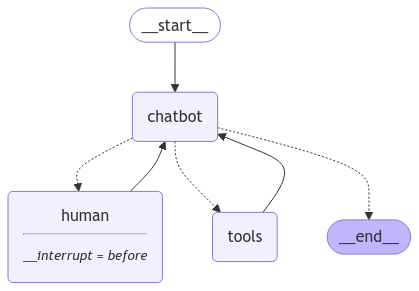

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

The chat bot can either request help from a human (chatbot->select->human), or invoke the search engine tool (chatbot->select->action), or directly respond (chatbot->select->end). 


Once an action or request has been made, the graph will transition back to the chatbot node to continue operations.

Let's see this graph in action. 


We will request for expert assistance to illustrate our graph.

In [ ]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"


config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!


events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (75451ffa-8441-472a-ae2b-221225e13f14)
 Call ID: 75451ffa-8441-472a-ae2b-221225e13f14
  Args:
    request: building an AI agent


**Notice:** the LLM has invoked the `"RequestAssistance"` tool we provided it, and the interrupt has been set. 

Let's inspect the graph state to confirm.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

The graph state is indeed interrupted before the 'human' node. We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

Next, respond to the chatbot's request by: 

1. Creating a `ToolMessage` with our response. This will be passed back to the `chatbot`. 

2. Calling `update_state` to manually update the graph state.

In [ ]:
ai_message = snapshot.values["messages"][-1]

human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

tool_message = create_response(human_response, ai_message)

graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1efa829a-a1b6-63b4-8002-99265b82be6b'}}

Inspect the state to confirm our response was added.

In [ ]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='05611438-a2d8-4b28-8d17-8e26fa9d0695'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-11-21T16:33:49.734333Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'RequestAssistance', 'arguments': {'request': 'building an AI agent'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 4829414333, 'load_duration': 813843833, 'prompt_eval_count': 293, 'prompt_eval_duration': 3773000000, 'eval_count': 21, 'eval_duration': 239000000}, id='run-e0af69b1-3d9c-4ccc-9431-3592ef2e0ea1-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'building an AI agent'}, 'id': '75451ffa-8441-472a-ae2b-221225e13f14', 'type': 'tool_call'}], usage_metadata={'input_tokens': 293, 'output_tokens': 21, 'total_tokens': 314}),
 ToolMessage(c

Next, **resume** the graph by invoking it with `None` as the inputs.

In [ ]:
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

It seems like we've requested assistance for building an AI agent. Based on our conversation, it appears that we're looking into using LangGraph as a potential solution.

LangGraph is a popular open-source framework for building and training neural networks. It's designed to be highly flexible and extensible, making it well-suited for complex tasks like building an AI agent.

To get started with LangGraph, you'll need to:


**Notice** that the chat bot has incorporated the updated state in its final response. 

Since everything was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

That's It! 

You've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. You did so by updating the graph `State` with a new `ask_human` field and modifying the interruption logic when compiling the graph. 

This lets you dynamically include a human in the loop while maintaining full memory every time you execute the graph.

## Part 7: Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in `"time travel"` functionality.

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. 

You can then resume execution at this previous point in time.

**First, recall our chatbot graph.**

Note: We don't need to make any changes from before:

In [ ]:
from typing import Annotated, Literal

from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, ToolMessage

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]
llm = ChatOllama(model="llama3.2", temperature=0)
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()

graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

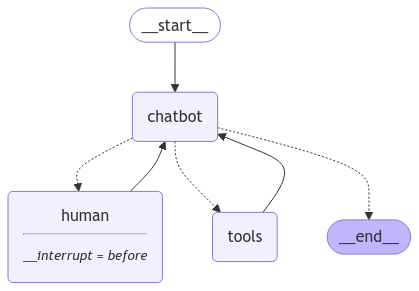

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. 

Note: Every step will be checkpointed in its state history:

In [ ]:
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (f3451b37-5d0e-4154-a8b1-1317d2d5d523)
 Call ID: f3451b37-5d0e-4154-a8b1-1317d2d5d523
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://langchain-ai.github.io/langgraph/", "content": "LangGraph is a framework for creating stateful, multi-actor applications with LLMs, using cycles, controllability, and persistence. Learn how to use LangGraph with LangChain, LangSmith, and Anthropic tools to build agent and multi-agent workflows."}, {"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem that simplifies the development of complex, multi-agen

**You see! It's sloppy. It should not have requested for Human input**

We will see how to fix this later.

In [ ]:
events = graph.stream(None, config, stream_mode="values")

for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (ec902874-b9aa-4f69-965c-59b05aecb1fe)
 Call ID: ec902874-b9aa-4f69-965c-59b05aecb1fe
  Args:
    request: I want to build an autonomous agent using LangGraph and need guidance on how to get started
================================= Tool Message =================================

No response from human.
================================== Ai Message ==================================

Based on the tool call response, here's a formatted answer to your original question:

Building an autonomous agent with LangGraph sounds like an exciting project! To get started, you'll want to familiarize yourself with the basics of LangGraph and its components.

First, let's break down the key concepts:

1. **Nodes**: Represent individual agents or entities in your system.
2. **Edges**: Define interactions between nodes, representing relationships or dependencies.
3. **State management**: Han

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [ ]:
to_replay = None

for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('human',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

**Note:** Checkpoints are saved for every step of the graph. 

This spans invocations so you can rewind across a full thread's history. 

We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.


Resuming from this point should call the `human` node next.

In [ ]:
print(to_replay.next)

print(to_replay.config)

('human',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efa8346-af04-65be-8006-b091f19f0c7d'}}


**Note:** The checkpoint's config `(to_replay.config)` contains a `checkpoint_id` timestamp.

Providing this `checkpoint_id` value tells LangGraph's checkpointer to load the state from that moment in time. 

Let's try it below:

In [ ]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (ec902874-b9aa-4f69-965c-59b05aecb1fe)
 Call ID: ec902874-b9aa-4f69-965c-59b05aecb1fe
  Args:
    request: I want to build an autonomous agent using LangGraph and need guidance on how to get started
================================= Tool Message =================================

No response from human.
================================== Ai Message ==================================

Based on the tool call response, here's a formatted answer to your original question:

Building an autonomous agent with LangGraph sounds like an exciting project! To get started, you'll want to familiarize yourself with the basics of LangGraph and its components.

First, let's break down the key concepts:

1. **Nodes**: Represent individual agents or entities in your system.
2. **Edges**: Define interactions between nodes, representing relationships or dependencies.
3. **State management**: Han

Notice that the graph resumed execution from the **human** node. 

You can tell this is the case since the first value printed above is the default response from the `ToolMessage` which indicates that the human did not respond.


Thats it! You've now used time-travel checkpoint traversal in LangGraph. 

Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

**NOTE: Depending on the LLM used, the output and behavior of your graph may vary.**